# 3D optical Luneburg lens

Luneburg lens is a prototypical gradient index (GRIN) optical component. A classical Luneburg lens is a spherical lens with a spatially varying refractive index profile following $n(r)=n_0\sqrt{2-(r/R)^2}$, where $r$ is the radial distance, $R$ is the radius of the lens, and $n_0$ is the refractive index of the ambient environment. Plane wave incident on a Luneburg lens will be focused to a point on the surface of the lens. Compared to a usual refractive lens, Luneburg lens is abberation-free and coma-free, which enables a wide range of applications in modern optical systems.

However, it is practically difficult to construct such a lens due to the required gradient index distribution. In the microwave regime, high-gain antennas based on a Luneburg lens design can be achieved by, for example, using concentric ceremics shells with different densities. In the optical frequencies, such an approach is generally not applicable. 

In this notebook, we demonstrate the numerical simulation of a practical 3D optical Luneburg lens. The structure consists of a large number of subwavelength unit cells. Using an effective medium approach, each unit cell can be approximated by a local effective index, which can be tuned by the filling fraction of the dielectric polymer in the unit cell. By varying the filling fraction of each unit cell such that the local effective index follows $n(r)=n_0\sqrt{2-(r/R)^2}$, a Luneburg lens is constructed. This design is adapted from [Zhao, Y. Y. et al. Three-dimensional Luneburg lens at optical frequencies. Laser Photonics Rev. 10, 665–672 (2016)](https://onlinelibrary.wiley.com/doi/abs/10.1002/lpor.201600051). In the simulation, a linearly polarized plane wave is launched towards the Luneburg lens. Through the visualization of the field distribution, the focusing capability of the lens can be assessed. We also compare the practical Luneburg lens design with the idealized case, which is simulated using [CustomMedium](../_autosummary/tidy3d.CustomMedium.html). The comparison result shows the practical Luneburg lens design is very optimal.

<img src="img/optical_luneburg_lens_schematic.png" width="600">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

import tidy3d as td
import tidy3d.web as web
from tidy3d import ScalarFieldDataArray
from tidy3d import PermittivityDataset

[15:14:14] WARNING  This version of Tidy3D was pip installed from the 'tidy3d-beta' repository on   ]8;id=299840;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\__init__.py\__init__.py]8;;\:]8;id=176418;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\__init__.py#104\104]8;;\
                    PyPI. Future releases will be uploaded to the 'tidy3d' repository. From now on,                
                    please use 'pip install tidy3d' instead.                                                       

           INFO     Using client version: 1.9.0rc2                                                  ]8;id=110813;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\__init__.py\__init__.py]8;;\:]8;id=279088;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\__init__.py#122\122]8;;\

           INFO     use cert file for web request:                                                     ]8;id=702952;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\config.py\config.py]8;;\:]8;id=401711;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\config.py#89\89]8;;\
                    C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\cacert.pem                                         

## Simulation Setup 

The Luneburg lens is designed to work in the mid-IR frequencies around 6.25 $\mu m$. Therefore, the spectrum of the source in the simulation is around this wavelength.

In [2]:
lda0 = 6.25  #central wavelength
ldas = np.linspace(5.25,7.25,10)  #simulation wavelength range
freq0 = td.C_0/lda0  #central frequency
freqs = td.C_0/ldas  #simulation frequency range
fwidth = 0.5*(np.max(freqs)-np.min(freqs))  #width of the frequency gaussian distribution

The period of the unit cell is 2 $\mu m$.

In [3]:
a = 2  #period of the unit cell

Only two materials are involved in this model -- the dielectric polymer and air. The polymer has a refractive index of 1.52 in mid-IR.

In [4]:
n_d = 1.52  #refractive index of the dielectric polymer
n_0 = 1  #refractive index of air

dielectric = td.Medium(permittivity=n_d**2)
air = td.Medium(permittivity=n_0**2)

The unit cell is a simply cubic with voids. We define the width of the polymer frames to be $w$. By tuning $w$ from 0 to 0.5$a$, the fillig fraction $f$ is changed from 0 to 1. Since the Luneburg lens structure consists of a large number of unit cells with varying geometries, it is convenient to define a function called `build_unit_cell` that takes in $w$ and the center coordinates and returns a unit cell structure. This function can then be called systematically later to construct the whole lens.

In [5]:
def build_unit_cell(w, x, y, z):
    unit_cell = []
    
    unit_cell.append(td.Structure(geometry=td.Box(center=(x,y,z),size=(a,a,a)),
                       medium=dielectric))
    
    unit_cell.append(td.Structure(geometry=td.Box(center=(x,y,z),size=(a-2*w,a-2*w,a)),
                       medium=air))
    
    unit_cell.append(td.Structure(geometry=td.Box(center=(x,y,z),size=(a-2*w,a,a-2*w)),
                       medium=air))
    
    unit_cell.append(td.Structure(geometry=td.Box(center=(x,y,z),size=(a,a-2*w,a-2*w)),
                       medium=air))
    
    return unit_cell

In this particular design, the radius of the Luneburg lens is 20 $\mu m$, i.e. 10 unit cells. The effective index at each site is the discretized version of $n(r)=n_0\sqrt{2-(r/R)^2}$. For our unit cell, the effective index scales approximately linearly with the filling fraction. Therefore, it is easy to obtain the desirable filling fraction at each unit cell.

In [6]:
N = 10  #number of unit cells from 0 to R
R = N*a   #radius of the Luneburg lens
r = np.linspace(a/2,R-a/2,N)  #distance of each unit cell to the origin
n_r = np.sqrt(2-(r/R)**2)  #desired effective index at each unit cell
f_r = (n_r-n_0)/(n_d-n_0)  #corresponding filling fraction at each unit cell

Since we wrote the `build_unit_cell` function with $w$ as the input argument, we need to know $w$ at each unit cell. This can be done through the relationship that $f=1-\frac{(a-2w)^2(a+4w)}{a^3}$. Here we simply use the `fsolve` function from the `Scipy` library to solve for $w$ with the given $f$. 

In [7]:
w_r = np.zeros(N)  #width of the polymer frame at each unit cell

#solve for w_r from f_r
for i,f in enumerate(f_r):
    def func(w):
        return 1-(a-2*w)**2*(a+4*w)/a**3-f
 
    w_r[i] = fsolve(func, 0.5)

With the obtained $w$ as a function of radial distance, we are ready to construct the Luneburg lens strucutre. This can be done easily through calling the `build_unit_cell` function in a neasted loops over the $x$, $y$, and $z$ coordinates of each unit cell.

Thanks to the symmetries, we only need to build a quater of the Luneburg lens structure. This drastically reduces the total number of Structures as well as the number of grid points of the model.

In [8]:
luneburg_lens=[]

for x in r:
    for y in r: 
        for z in np.linspace(-R+a/2,R-a/2,2*N):
            r_local = np.sqrt(x**2+y**2+z**2)  #radial distance of the unit cell
            #build an unit cell if the radial distance is smaller or equal to the lens radius
            if r_local <= R:
                luneburg_lens.extend(build_unit_cell(np.interp(r_local,r,w_r),x,y,z))
    

Next, we define a PlaneWave source and two [FieldMonitors](../_autosummary/tidy3d.FieldMonitor.html?highlight=fieldmonitor), one in the $xz$ plane at $y=0$ and one in the $xy$ plane at $z=R$. The focus is supposed to be at $z=R$ so we can visualize the focal spot through the second FieldMonitor.

In [9]:
#define a plane wave source
plane_wave = td.PlaneWave(
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    size=(td.inf, td.inf, 0),
    center=(0, 0, -11*a),
    direction="+",
    pol_angle=0,
)

#define a field monitor in the xz plane at y=0
monitor_field_xz = td.FieldMonitor(
    center=[0, 0, 0], size=[td.inf, 0, td.inf], freqs=[freq0], name="field_xz"
)

#define a field monitor in the xy plane at z=R
monitor_field_xy = td.FieldMonitor(
    center=[0, 0, R], size=[td.inf, td.inf, 0], freqs=[freq0], name="field_xy"
)


Finally, we are ready to define the simulation with the above defined structures, source, and monitors.

In [10]:
#simulation domain size
Lx, Ly, Lz = 25*a, 25*a, 30*a
sim_size = (Lx, Ly, Lz)

run_time = 3e-12 #simulation run time

#define simulation
sim = td.Simulation(
    center=(0,0,2*a),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=30, wavelength=lda0),
    structures=luneburg_lens,
    sources=[plane_wave],
    monitors=[monitor_field_xz,monitor_field_xy],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),  #pml is applied in all boundaries
    symmetry=(-1,1,0)  #symmetry is used such that only a quarter of the structure needs to be modeled.
) 

To visualize the simulation, especially the structures, we use the `plot` function of [Simulation](../_autosummary/tidy3d.Simulation.html?highlight=simulation). More specifically, we can look at the slice through the $xz$ plane at $y=0$. From the plot, we can see the unit cells with varying filling fraction as well as the source and monitors are set up correctly.

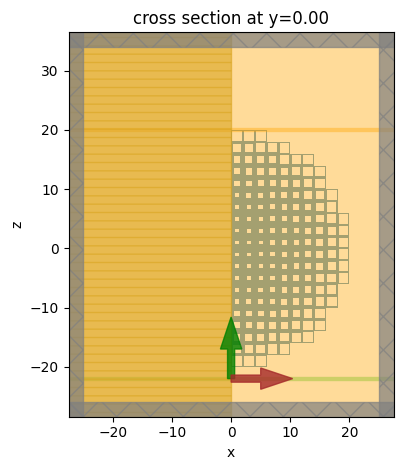

In [11]:
sim.plot(y=0);

Submit the simulation job to the server. We name the simulation data `sim_data_practical` to distinguish the simulation data for the idealizd Luneburg lens later on.

In [12]:
sim_data_practical = web.run(
sim, task_name="practical_luneburg_lens", path="data/simulation_data.hdf5"
)

[15:14:17] INFO     Using Tidy3D credentials from stored file.                                           ]8;id=395632;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\auth.py\auth.py]8;;\:]8;id=305499;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\auth.py#77\77]8;;\

[15:14:18] INFO     Authentication successful.                                                           ]8;id=261267;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\auth.py\auth.py]8;;\:]8;id=306182;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\auth.py#37\37]8;;\

[15:14:19] INFO     Created task 'practical_luneburg_lens' with task_id                               ]8;id=782005;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=959707;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#120\120]8;;\
                    'a73fd0b3-1a4a-4f4a-8a9e-8159b3882ec6'.                                                        

Output()

[15:14:25] INFO     status = queued                                                                   ]8;id=446515;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=831454;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#262\262]8;;\

Output()

[15:14:34] INFO     Maximum FlexUnit cost: 0.205                                                      ]8;id=425843;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=313051;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#253\253]8;;\

[15:14:37] INFO     status = preprocess                                                               ]8;id=241568;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=56554;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#274\274]8;;\

[15:14:46] INFO     starting up solver                                                                ]8;id=897432;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=902934;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#278\278]8;;\

[15:14:56] INFO     running solver                                                                    ]8;id=992767;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=843495;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#284\284]8;;\

Output()

[15:17:41] INFO     early shutoff detected, exiting.                                                  ]8;id=747866;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=706238;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#295\295]8;;\

           INFO     status = postprocess                                                              ]8;id=179292;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=941799;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#301\301]8;;\

Output()

[15:17:47] INFO     status = success                                                                  ]8;id=530013;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=819547;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.000                                                       ]8;id=342210;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=205965;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to "data/simulation_data.hdf5"        ]8;id=196986;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=937811;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#593\593]8;;\

Output()

[15:17:49] INFO     loading SimulationData from data/simulation_data.hdf5                             ]8;id=269406;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=388325;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#415\415]8;;\

## Result Visualization

First, let's visualize the field intensity as well as $E_x$ in the $xz$ plane. A strong intensity spot is observed around $z=R$, indicating the good focus capability of the designed Luneburg lens. From the $E_x$ plot, we can see the wave front gradually converges due to the locally varying effective refractive index.

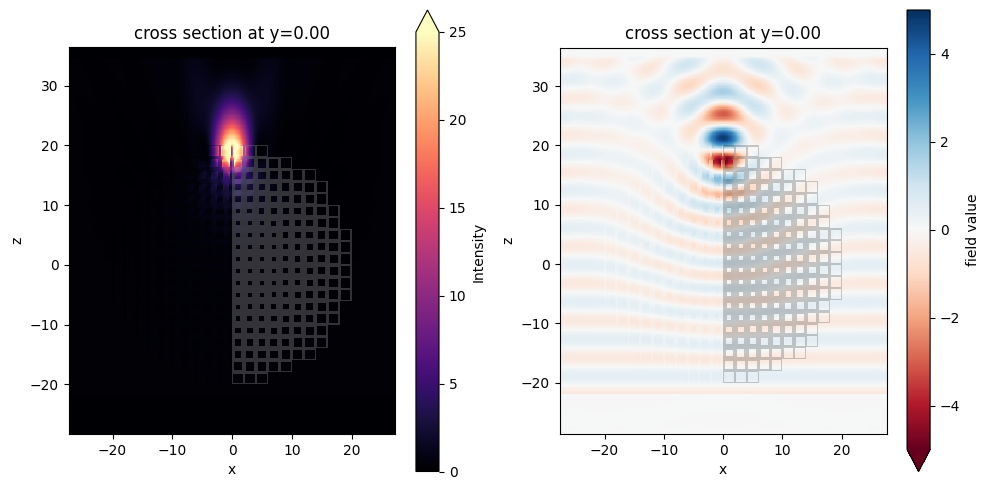

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2,tight_layout=True, figsize=(10, 5))

#plot field intensity at the xz plane
sim_data_practical.plot_field("field_xz", "int", ax = ax1, vmin=0, vmax=25)

#plot Ex at the xz plane
sim_data_practical.plot_field("field_xz", "Ex", ax = ax2, vmin=-5, vmax=5);

To further investigate the focusing, we plot several intensity profiles around the focus. The intensity and width of the focus can be clearly observed from this plot.

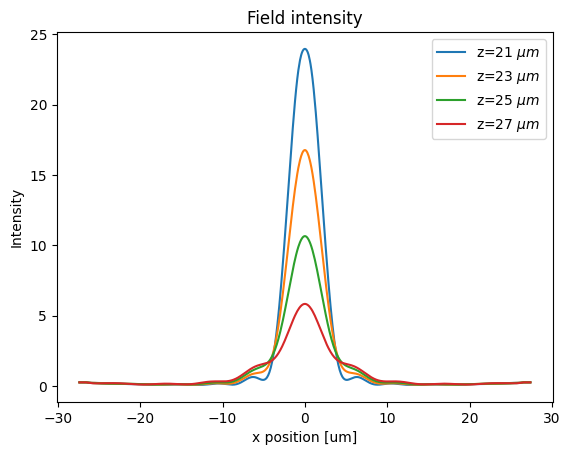

In [14]:
zs = [21, 23, 25, 27]  #z coordinates of the field profile slices

#plot intensity profiles
fig, ax = plt.subplots()
for z in zs:
    I  = sim_data_practical.get_intensity('field_xz').sel(z=z, method='nearest')
    I.plot(ax = ax, label=f'z={z} $\mu m$')
ax.legend()
ax.set_title('Field intensity');

Lastly, plot the intensity distribution in the $xy$ plane to visualize the focal spot shape.

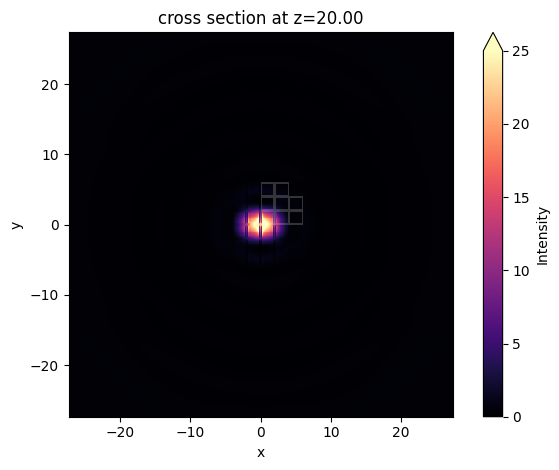

In [15]:
sim_data_practical.plot_field("field_xy", "int", vmin=0, vmax=25);

## Comparison to the Ideal Luneburg Lens 

As a comparison, we simulate an ideal Luneburg lens whose local refractive index follows exactly according to $n(r)=n_0\sqrt{2-(r/R)^2}$. This can be realized in `Tidy3D` using the [CustomMedium](../_autosummary/tidy3d.CustomMedium.html), which conveniently defines a spatially varying refractive index profile within one structure. 

First, we define the spatial and frequency grids and define a 4-dimensional array that stores the refractive index.

In [16]:
Nx, Ny, Nz, Nf = 100, 100, 100, 1  #number of grid points along each dimension

X = np.linspace(-R, R, Nx) #x grid
Y = np.linspace(-R, R, Ny) #y grid
Z = np.linspace(-R, R, Nz) #z grid
freqs = [freq0] #frequency grid

# define coordinate array
x_mesh, y_mesh, z_mesh, freq_mesh = np.meshgrid(X,Y,Z,freqs,indexing="ij")
r_mesh = np.sqrt(x_mesh**2+y_mesh**2+z_mesh**2)

# index of refraction array
#assign the refractive index value to the array according to the desired profile
n_data = np.ones((Nx,Ny,Nz,Nf))
n_data[r_mesh<=R] = np.sqrt(2-(r_mesh[r_mesh<=R]/R)**2)

The numpy array is converted to a ScalarFieldDataArray that labels the coordinate. A custome medium is then defined using the classmethod [td.CustomMedium.from_nk](../_autosummary/tidy3d.CustomMedium.html#tidy3d.CustomMedium.fron_nk). Finally, the lens structure is defined.

In [17]:
# convert to dataset array
n_dataset = ScalarFieldDataArray(n_data, coords=dict(x=X, y=Y, z=Z, f=freqs))

# define custom medium based on the dataset
mat_custom = td.CustomMedium.from_nk(n_dataset, interp_method='nearest')

#define the ideal luneburg lens structure
lens = td.Structure(geometry=td.Sphere(radius=R), medium=mat_custom)

Most simulation setup from the previous section can be readily reused. Therefore, we simply copy the previous simulation and only update the structures to contain the ideal Luneburg lens. Using the `plot_eps` method we can visualize the gradient permittivity distribution. 

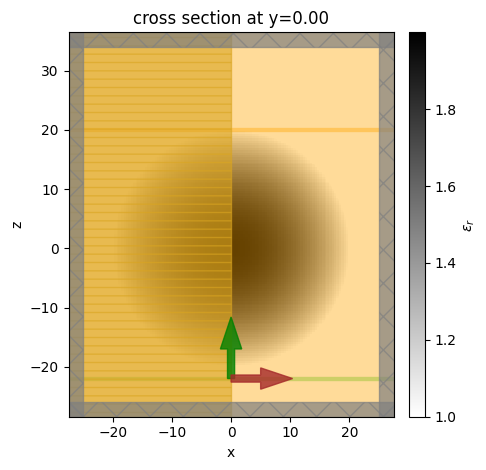

In [18]:
sim = sim.copy(update={"structures":[lens]})
sim.plot_eps(y=0);

Submit the simulation job to the server.

In [19]:
sim_data_ideal = web.run(
sim, task_name="ideal_luneburg_lens", path="data/simulation_data.hdf5"
)

[15:17:57] INFO     Created task 'ideal_luneburg_lens' with task_id                                   ]8;id=287303;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=703893;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#120\120]8;;\
                    'b1e5a705-954a-432e-a487-2f53f57027df'.                                                        

Output()

Output()

[15:18:20] INFO     status = queued                                                                   ]8;id=759683;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=68682;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#262\262]8;;\

Output()

[15:18:24] INFO     Maximum FlexUnit cost: 0.040                                                      ]8;id=104555;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=682732;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#253\253]8;;\

[15:18:29] INFO     status = preprocess                                                               ]8;id=855146;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=996388;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#274\274]8;;\

[15:18:33] INFO     starting up solver                                                                ]8;id=402648;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=125302;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#278\278]8;;\

[15:18:44] INFO     running solver                                                                    ]8;id=787297;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=822049;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#284\284]8;;\

Output()

[15:18:47] INFO     early shutoff detected, exiting.                                                  ]8;id=683022;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=494019;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#295\295]8;;\

           INFO     status = postprocess                                                              ]8;id=256423;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=787368;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#301\301]8;;\

Output()

[15:19:02] INFO     status = success                                                                  ]8;id=493004;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=490838;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.000                                                       ]8;id=983128;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=375543;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#311\311]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to "data/simulation_data.hdf5"        ]8;id=728568;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=590843;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#593\593]8;;\

Output()

[15:19:06] INFO     loading SimulationData from data/simulation_data.hdf5                             ]8;id=470363;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=272633;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#415\415]8;;\

We perform the same postprocessing visualizations as in the previous section. The results of the designed Luneburg lens are very similar to the idealized case, confirming the validity of the design using the effective index approach.

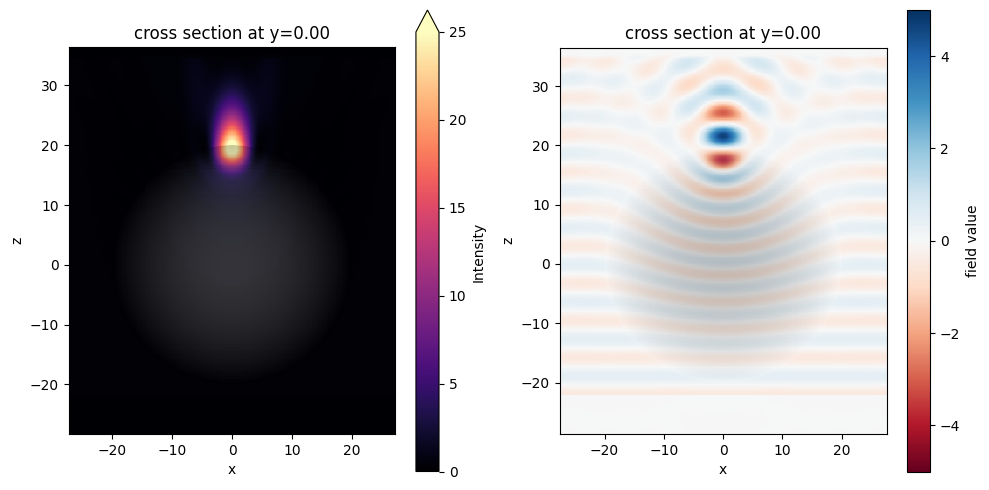

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2,tight_layout=True, figsize=(10, 5))

#plot field intensity at the xz plane
sim_data_ideal.plot_field("field_xz", "int", ax = ax1, vmin=0, vmax=25)

#plot Ex at the xz plane
sim_data_ideal.plot_field("field_xz", "Ex", ax = ax2, vmin=-5, vmax=5);

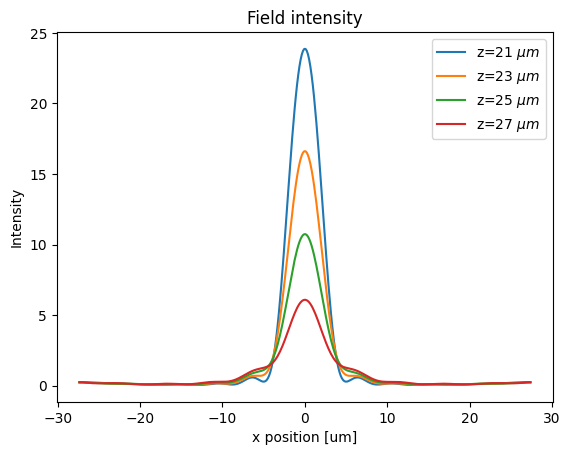

In [21]:
#plot intensity profiles
fig, ax = plt.subplots()
for z in zs:
    I  = sim_data_ideal.get_intensity('field_xz').sel(z=z, method='nearest')
    I.plot(ax = ax, label=f'z={z} $\mu m$')
ax.legend()
ax.set_title('Field intensity');

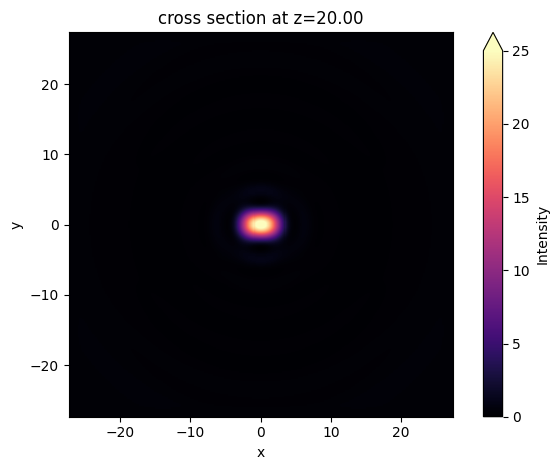

In [22]:
sim_data_ideal.plot_field("field_xy", "int", vmin=0, vmax=25);

Lastly, as a direct comparison, we plot the field intensity around the focus for the practical and idealized Luneburg lens together. The resutls are nearly identical, which validates the design of the practical Lunebug lens.

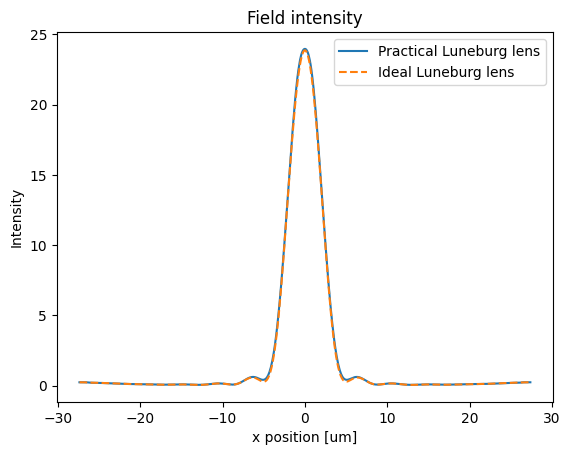

In [23]:
#compare ideal and practical Luneburg lens intensity profiles at fix z

z = 21

fig, ax = plt.subplots()

I_practical  = sim_data_practical.get_intensity('field_xz').sel(z=z, method='nearest')
I_practical.plot(ax = ax, label='Practical Luneburg lens')

I_ideal  = sim_data_ideal.get_intensity('field_xz').sel(z=z, method='nearest')
I_ideal.plot( linestyle = '--', ax = ax, label='Ideal Luneburg lens')

ax.legend()
ax.set_title('Field intensity');